## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [1]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch


In [2]:
! pip install scikit-plot
! pip install 'portalocker>=2.0.0'

In [3]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc


In [4]:
# # Use GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)



cuda


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [5]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)


In [6]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)


In [7]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])


In [8]:
#test tokens
tokens = tokeniser('Welcome to TE3007')
print(tokens, vocab(tokens))


['welcome', 'to', 'te3007'] [3314, 4, 0]


In [9]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN


In [10]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])


In [11]:
print(len(train_dataset), len(val_dataset), len(test_dataset))


108000 12000 7600


In [12]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1


In [13]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256


In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)


### Let us build our RNN model

In [15]:
EMBEDDING_SIZE = 20
NEURONS = 64
LAYERS = 2
NUM_CLASSES = 4



In [16]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden,
                           num_layers=layers,
                           batch_first=True)
        # pass # complete this code/
                        # You may use PyTorch nn.GRU(), nn.RNN(), or nn.LSTM()

        self.fc = nn.Linear(hidden, num_classes)
        # pass # complete output classifier layer using linear layer

    def forward(self, x):
        out = self.embedding_layer(x)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc(out)
        return out
        # implement forward pass. This function will be called when executing the model


In [17]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(dim=1)
            num_correct += (predictions == y).sum()
            num_total += predictions.size(0)
    return float(num_correct) / num_total


In [18]:
def train(model, optimiser, epochs=100):
    model.to(device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()

            xi = xi.to(device=device, dtype=torch.long)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input=scores, target=yi)

            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

        acc = accuracy(model, val_loader)
        print("Epoch: %d, Accuracy: %0.2f" % (epoch, acc))



In [19]:
epochs = 30
lr = 0.0001
# instantiate model
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)


rnn_model


RNN_Model_1(
  (embedding_layer): Embedding(95811, 20)
  (rnn): LSTM(20, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [20]:
train(rnn_model, optimiser=optimiser, epochs=epochs)


Epoch: 0, Accuracy: 0.29
Epoch: 1, Accuracy: 0.41
Epoch: 2, Accuracy: 0.49
Epoch: 3, Accuracy: 0.56
Epoch: 4, Accuracy: 0.61
Epoch: 5, Accuracy: 0.65
Epoch: 6, Accuracy: 0.69
Epoch: 7, Accuracy: 0.72
Epoch: 8, Accuracy: 0.74
Epoch: 9, Accuracy: 0.76
Epoch: 10, Accuracy: 0.77
Epoch: 11, Accuracy: 0.78
Epoch: 12, Accuracy: 0.79
Epoch: 13, Accuracy: 0.80
Epoch: 14, Accuracy: 0.81
Epoch: 15, Accuracy: 0.82
Epoch: 16, Accuracy: 0.82
Epoch: 17, Accuracy: 0.83
Epoch: 18, Accuracy: 0.83
Epoch: 19, Accuracy: 0.84
Epoch: 20, Accuracy: 0.84
Epoch: 21, Accuracy: 0.85
Epoch: 22, Accuracy: 0.85
Epoch: 23, Accuracy: 0.86
Epoch: 24, Accuracy: 0.85
Epoch: 25, Accuracy: 0.86
Epoch: 26, Accuracy: 0.86
Epoch: 27, Accuracy: 0.86
Epoch: 28, Accuracy: 0.87
Epoch: 29, Accuracy: 0.87


In [27]:
print(f'{accuracy(rnn_model, test_loader):.4f}')


0.8654


In [28]:
def sample_text(model, loader):
    # Function to sample text to try the model
    model.eval()
    model.to(device=device)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, predictions = scores.max(dim=1)
            # print convert from tensor to text
            print(f'Predicted: {labels[predictions[0]]}, Actual: {labels[y[0]]}')
            break


In [29]:
sample_text(rnn_model, test_loader)


Predicted: Sci/Tech, Actual: Sci/Tech


In [30]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


In [31]:

def plot_confusion_matrix(model, loader):
  model.eval()
  model.to(device=device)

  y_true = []
  y_pred = []

  with torch.no_grad():
      for x, y in loader:
          x = x.to(device=device)
          y = y.to(device=device)
          scores = model(x)
          _, predictions = scores.max(dim=1)
          y_true.extend(y.cpu().numpy())
          y_pred.extend(predictions.cpu().numpy())

  cm = confusion_matrix(y_true, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot()



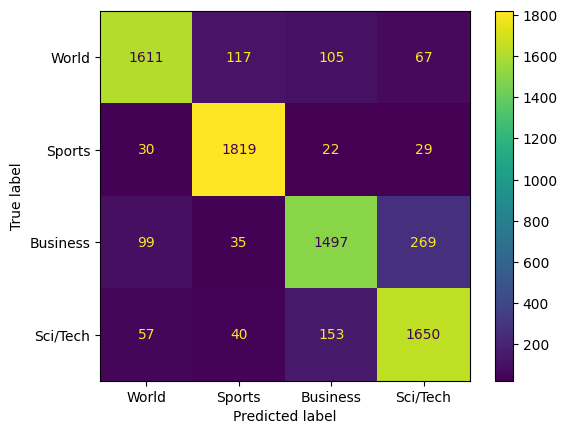

In [32]:
plot_confusion_matrix(rnn_model, test_loader)